In [5]:
import ROOT
# create a smaller events - 10k of file
file_name='/home/prozorov/dev/star/jets_pp_2012/output/matched_jets.root'
tree_name = 'MatchedTree' 
f = ROOT.TFile.Open(file_name)
tree = f.Get(tree_name)
# create a new file
f_out = ROOT.TFile('matched_jets_small.root', 'RECREATE')
# create a new tree
tree_out = tree.CloneTree(0)

for i in range(20000):
    tree.GetEntry(i)
    # exlude mc_pt==-9 and reco_pt==-9
    if tree.mc_pt == -9 or  tree.reco_pt == -9:
        continue
    # clone the entry to the new tree
    tree_out.Fill()
# write the new tree to the new file
f_out.Write()
# close the files
f_out.Close()





In [1]:
import ROOT
import uproot

file_name='/home/prozorov/dev/star/jets_pp_2012/output/matched_jets.root'
tree_name = 'MatchedTree'  # Update this to your tree name
my_file = uproot.open(file_name)
all_branches= ['mc_pt', 'mc_eta', 'mc_phi', 'mc_neutral_fraction', 'mc_trigger_match',
            'mc_n_constituents', 'mc_event_id', 'mc_weight', 'mc_multiplicity',
            'mc_is_rejected', 'reco_pt', 'reco_eta', 'reco_phi', 'reco_neutral_fraction',
            'reco_trigger_match', 'reco_n_constituents', 'reco_event_id', 'reco_weight',
            'reco_multiplicity', 'reco_is_rejected', 'deltaR'
    ]
selected_branches = ['mc_pt',   'mc_eta',   'mc_phi',   'mc_weight',
                     'reco_pt', 'reco_eta', 'reco_phi', 'reco_trigger_match',  'deltaR'
    ]
my_tree = my_file[tree_name]
# Get the branches from the tree , limit the number of events to 100000
branches = my_tree.arrays(all_branches, library='pd', entry_stop=100000)
# separately have fake_jets(mc_pt=-9),  miss_jets (reco_pt=-9) and matched jets
fake_jets = branches[branches['mc_pt'] == -9]
miss_jets = branches[branches['reco_pt'] == -9]
matched_jets = branches[branches['mc_pt'] != -9]
matched_jets = matched_jets[matched_jets['reco_pt'] != -9]

In [2]:
matched_jets

,mc_pt,mc_eta,mc_phi,mc_neutral_fraction,mc_trigger_match,mc_n_constituents,mc_event_id,mc_weight,mc_multiplicity,mc_is_rejected,...,reco_eta,reco_phi,reco_neutral_fraction,reco_trigger_match,reco_n_constituents,reco_event_id,reco_weight,reco_multiplicity,reco_is_rejected,deltaR
0,6.909035,-0.516449,0.271741,0.260088,False,7,-22.524172,7.671934e-10,22.0,False,...,-0.509194,0.264706,0.416166,False,11,-22.850000,7.671934e-10,43.0,False,0.031333
1,7.770895,-0.332599,-0.235722,0.937188,False,4,19.216461,7.671934e-10,15.0,False,...,-0.294396,-0.108441,0.121049,False,5,19.750000,7.671934e-10,19.0,False,0.130478
2,5.072170,-0.362110,-0.082607,0.398680,False,5,-23.803522,7.671934e-10,37.0,False,...,-0.339611,-0.074796,0.404031,False,7,-23.950001,7.671934e-10,48.0,False,0.020837
4,7.017721,-0.114239,2.200750,0.829434,False,6,-8.078520,7.671934e-10,22.0,False,...,-0.159542,2.288759,0.343645,False,8,-8.050000,7.671934e-10,32.0,False,0.099164
5,10.088763,0.463288,-1.057688,0.042192,False,6,-4.106014,7.671934e-10,18.0,False,...,0.400984,-1.134317,0.135799,False,9,-4.050000,7.671934e-10,32.0,False,0.092128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,5.620756,-0.521116,-1.577254,0.168523,False,3,1.783999,7.671934e-10,23.0,False,...,-0.560075,-1.601176,0.106729,False,4,1.650000,7.671934e-10,43.0,False,0.048477
99993,10.871931,-0.269193,-1.894790,0.544153,False,8,-4.445392,7.671934e-10,21.0,False,...,-0.293760,-1.945335,0.317908,False,7,-4.450000,7.671934e-10,31.0,False,0.065270
99997,11.528017,-0.054871,-1.269447,0.749668,False,5,23.474188,7.671934e-10,32.0,False,...,-0.048285,-1.273403,0.259309,True,8,23.450001,7.671934e-10,44.0,False,0.007210
99998,10.511450,0.250774,3.133856,0.000000,False,5,28.041048,7.671934e-10,37.0,False,...,0.249309,3.122861,0.043007,False,7,28.049999,7.671934e-10,55.0,False,0.011052


mc_pt


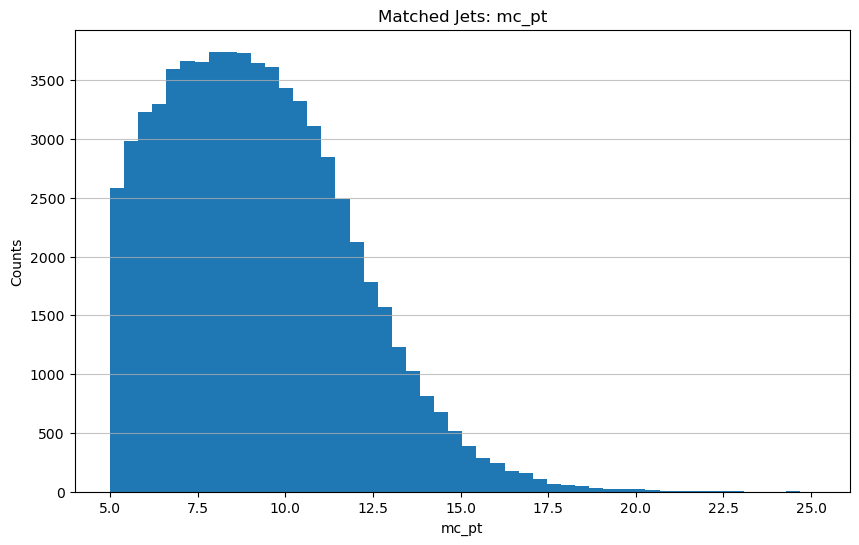

mc_eta


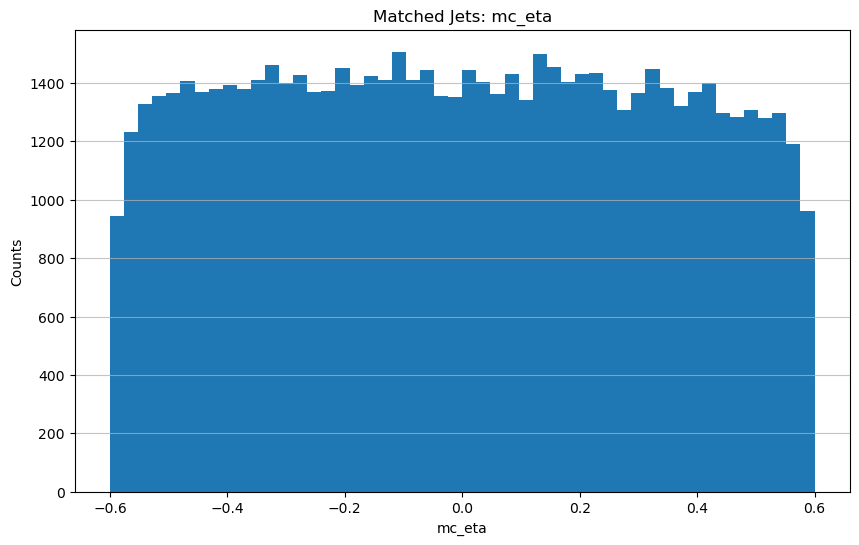

mc_phi


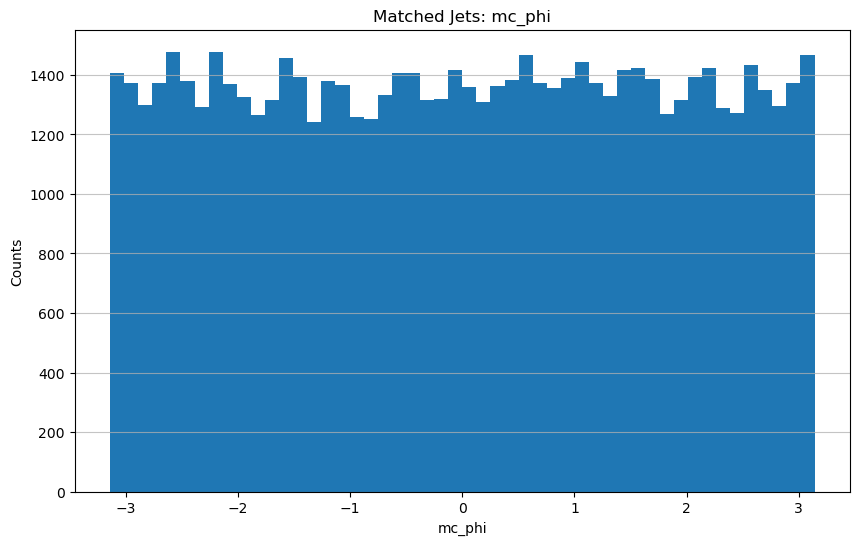

mc_neutral_fraction
mc_trigger_match
mc_n_constituents
mc_event_id
mc_weight


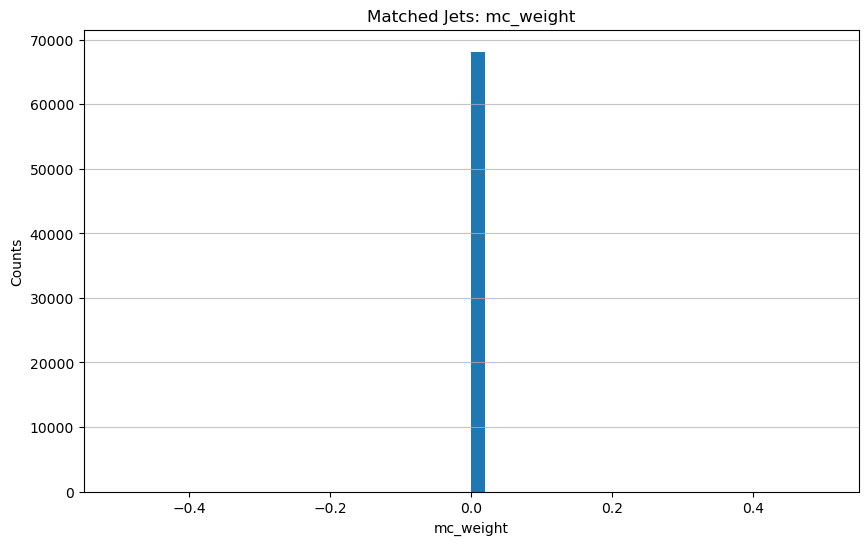

mc_multiplicity
mc_is_rejected
reco_pt


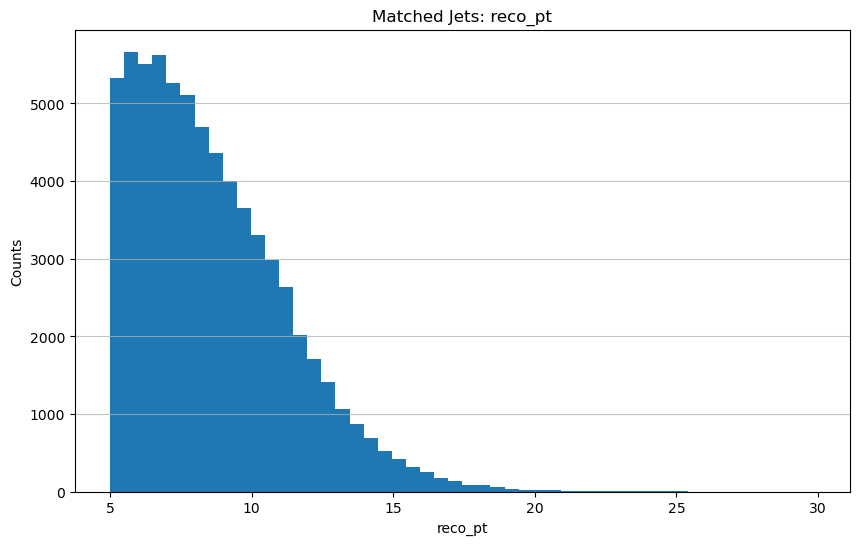

reco_eta


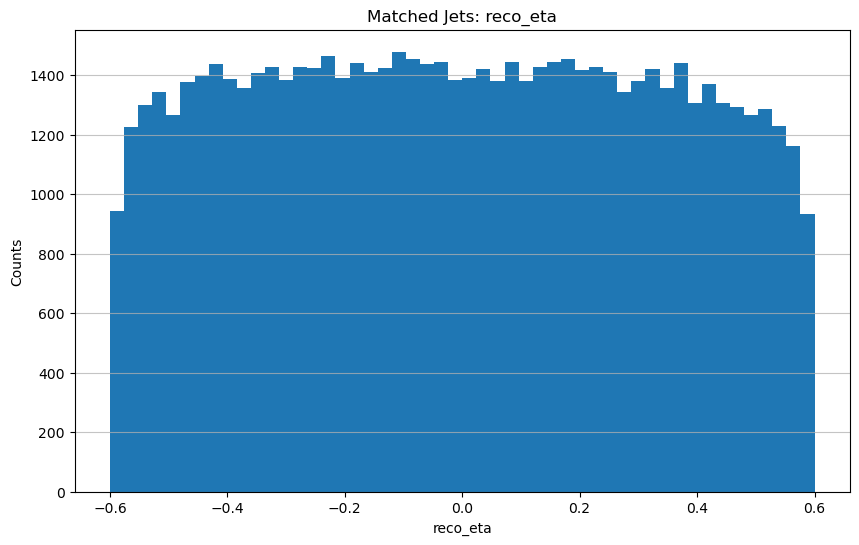

reco_phi


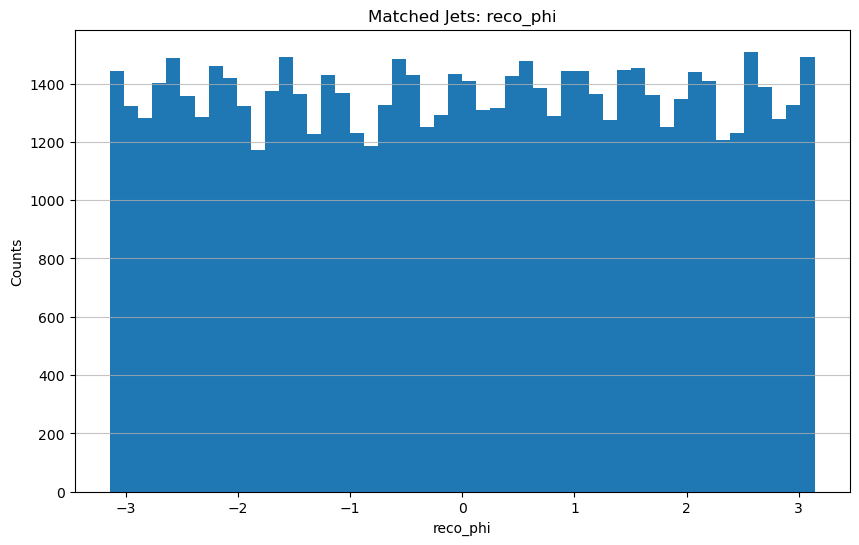

reco_neutral_fraction
reco_trigger_match


/home/prozorov/dev/star/jets_pp_2012/macros/ana/.conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

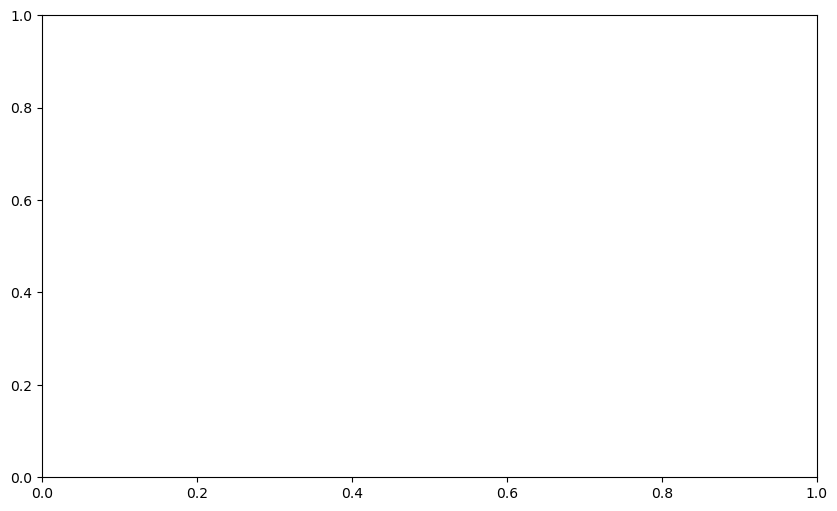

In [3]:
# plot all distributions for the matched jets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plot_histogram(data, title, xlabel, ylabel, bins=50):
    plt.figure(figsize=(10, 6))
    # check if datatype is boolean
    if isinstance(data[0], bool):
        data = [int(x) for x in data]
    # check if datatype is string
    elif isinstance(data[0], str):
        data = [float(x) for x in data]
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plotting histograms for matched jets
for branch in all_branches:
    print(branch)
    if branch in selected_branches:
        data = matched_jets[branch]
        title = f"Matched Jets: {branch}"
        xlabel = branch
        ylabel = "Counts"
        plot_histogram(data, title, xlabel, ylabel)
    else:
        continue   